In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as ss
import numpy as np
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import normalize
from sklearn.base import BaseEstimator
from sklearn.utils import check_array
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
from os.path import isfile
import subprocess

In [2]:
data_dir = '/home/ed/github/pod_tweets/follower_ids/'
pod_list = os.listdir(data_dir)
num_pods = len(pod_list)

In [3]:
def calc_common_usrs(data_dir, pod1, pod2):
    pod_list1 = [line.rstrip('\n') for line in open(data_dir + pod1)]
    pod_list1.pop(0)
    pod_list2 = [line.rstrip('\n') for line in open(data_dir + pod2)]
    pod_list2.pop(0)
    num_same = set(pod_list1) & set(pod_list2)
    return len(num_same), len(pod_list1), len(pod_list2)

In [4]:
pod_common_usrs = pd.DataFrame(columns = ['podcast_1', 'podcast_2', 'comm_users'])
pod_popularity = pd.DataFrame(pod_list, columns=['podcast'])
pod_popularity['followers'] = 0
pod_popularity = pod_popularity.set_index('podcast')

for x1 in range(num_pods):
    for x2 in range(x1+1, num_pods):
        print('{}:{} of {}'.format(x1, x2, num_pods), end='\r', flush=True)
        comm_num, pod_x1, pod_x2 = calc_common_usrs(data_dir, pod_list[x1], pod_list[x2])
        pod_common_usrs.loc[len(pod_common_usrs)] = [pod_list[x1], pod_list[x2], comm_num]
        pod_popularity.at[pod_list[x1], 'followers'] = pod_x1
        pod_popularity.at[pod_list[x2], 'followers'] = pod_x2
pod_common_usrs

,podcast_1,podcast_2,comm_users
0,TheMinimalistsPodcast.csv,WithFriendsLikeThese.csv,34
1,TheMinimalistsPodcast.csv,AndThatsWhyWeDrink.csv,10
2,TheMinimalistsPodcast.csv,AlisonRosenIsYourNewBestFriend.csv,11
3,TheMinimalistsPodcast.csv,IAMRAPAPORTSTEREOPODCAST.csv,11
4,TheMinimalistsPodcast.csv,AliceIsntDead.csv,6
...,...,...,...
17386,thememorypalace.csv,TheBenandAshleyIAlmostFamousPodcast.csv,2
17387,thememorypalace.csv,SomethingtoWrestlewithBrucePrichard.csv,7
17388,TheJordanBPetersonPodcast.csv,TheBenandAshleyIAlmostFamousPodcast.csv,6
17389,TheJordanBPetersonPodcast.csv,SomethingtoWrestlewithBrucePrichard.csv,16


In [5]:
pod_common_usrs.to_csv('pod_common_users223.csv')

In [30]:
df = pod_common_usrs[pod_common_usrs['podcast_1'] == 'KnowledgeFight' + '.csv']
df = df[df['podcast_2'] == 'BehindtheBastards' + '.csv']
X = df['comm_users'].tolist()

if not X:
    df = pod_common_usrs[pod_common_usrs['podcast_1'] == 'BehindtheBastards' + '.csv']
    df = df[df['podcast_2'] == 'KnowledgeFight' + '.csv']
    X = df['comm_users'].tolist()

comm_users = X[0]
comm_users

2058

In [5]:
pod_popularity = pod_popularity.sort_values(by='followers', ascending=False)
pod_pop_arr = np.array(pod_popularity.index)
pod_pop_arr[:10]

array(['60Minutes.csv', '48Hours.csv', '1A.csv', '99Invisible.csv',
       'BehindtheBastards.csv', '83WeekswithEricBischoff.csv',
       'AccidentalTechPodcast.csv', 'JudgeJohnHodgman.csv',
       'CLUBLIFE.csv', 'AndThatsWhyWeDrink.csv'], dtype=object)

In [6]:
index_map = dict(np.vstack([pod_pop_arr, np.arange(pod_pop_arr.shape[0])]).T)
# index_map  # dict of key:value == pod:rank

In [7]:
count_matrix = ss.coo_matrix((pod_common_usrs.comm_users, 
                              (pod_common_usrs.podcast_2.map(index_map),
                               pod_common_usrs.podcast_1.map(index_map))),
                             shape=(pod_pop_arr.shape[0], pod_pop_arr.shape[0]),
                             dtype=np.float64)
count_matrix

<71x71 sparse matrix of type '<class 'numpy.float64'>'
	with 2485 stored elements in COOrdinate format>

In [8]:
conditional_prob_matrix = count_matrix.tocsr()
conditional_prob_matrix = normalize(conditional_prob_matrix, norm='l1', copy=False)
conditional_prob_matrix

<71x71 sparse matrix of type '<class 'numpy.float64'>'
	with 2485 stored elements in Compressed Sparse Row format>

In [9]:
# reduced_vectors = TruncatedSVD(n_components=3, random_state=1).fit_transform(conditional_prob_matrix)
# reduced_vectors = normalize(reduced_vectors, norm='l2', copy=False)
# reduced_vectors

reduced_vectors = TSNE(n_components=2, perplexity=10).fit_transform(conditional_prob_matrix)
reduced_vectors = normalize(reduced_vectors, norm='l2', copy=False)
reduced_vectors[:10]

array([[-0.1489858 ,  0.9888393 ],
       [ 0.46112198, -0.8873368 ],
       [ 0.537233  , -0.8434339 ],
       [ 0.9025458 , -0.43059394],
       [ 0.6942723 ,  0.7197124 ],
       [-0.6147831 , -0.7886962 ],
       [ 0.11583471,  0.9932685 ],
       [ 0.45443904,  0.8907778 ],
       [-0.68658787, -0.7270469 ],
       [-0.99997157, -0.00754079]], dtype=float32)

In [10]:
# from joblib import dump, load

# resources_dir = '/home/ed/github/pod_tweets/resources/'

# data_dump = resources_dir + '20190402_data.joblib'
# reduced_data = load(data_dump)

In [11]:
reduced_data = TruncatedSVD(n_components=2).fit_transform(conditional_prob_matrix)
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
kmeans.fit(reduced_data)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [12]:
from joblib import dump, load

resources_dir = '/home/ed/github/pod_tweets/resources/'

# data_dump = resources_dir + '20190402_kmeans_data.joblib'
# dump(reduced_data, data_dump)

In [18]:
pod_space_df = pd.DataFrame(reduced_data, columns=('x', 'y'))
pod_space_df['pod_name'] = pod_pop_arr
pod_space_df['pod_name'] = pod_space_df.pod_name.str[:-4]
pod_space_df = pod_space_df.sort_values(by='pod_name', ignore_index=True)
pod_space_df.to_pickle(resources_dir + 'pod_space_df.pkl')
pod_space_df.head()

,x,y,pod_name
0,0.552553,-0.185663,1A
1,0.677453,-0.240004,1YearDailyAudioBible
2,0.266890,-0.034361,2DopeQueens
3,0.398905,-0.057144,30For30Podcasts
4,0.823851,-0.311455,48Hours


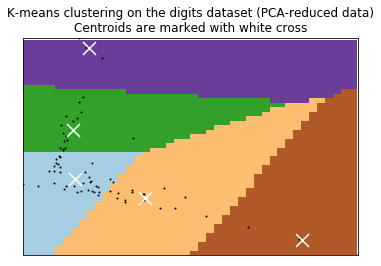

In [19]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min(), reduced_data[:, 0].max()
y_min, y_max = reduced_data[:, 1].min(), reduced_data[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [57]:
final_matrix = pd.read_pickle(resources_dir + 'final_matrix.pkl')

topic_pkl = 'topic_matrix_202002121312.pkl'
rank_pkl = 'rank_matrix_202002121312.pkl'

topic_matrix = pd.read_pickle(resources_dir + topic_pkl)
rank_matrix = pd.read_pickle(resources_dir + rank_pkl)

pods_list = rank_matrix.columns.to_list()

In [47]:
topic_matrix_norm = normalize(topic_matrix, norm='l2', copy=False)

In [58]:
reduced_data = TruncatedSVD(n_components=2).fit_transform(topic_matrix_norm)
reduced_data[:10]

array([[ 9.86421579e-01, -3.17292031e-04],
       [ 9.63891623e-01, -6.90299231e-02],
       [ 9.80093183e-01,  2.18914080e-02],
       [ 9.73413509e-01, -8.12129892e-02],
       [ 9.80334782e-01,  8.67905495e-02],
       [ 9.85463436e-01, -2.60688330e-02],
       [ 9.73922818e-01, -5.33995204e-02],
       [ 9.87656448e-01,  2.61546781e-02],
       [ 9.82389795e-01,  2.23062765e-02],
       [ 9.86702962e-01, -9.76932553e-03]])

In [59]:
import hdbscan

clustering_martrix = pd.DataFrame(reduced_data, columns=['x', 'y'])

clusterer = hdbscan.HDBSCAN(min_samples=15, metric='manhattan', 
                            min_cluster_size=2).fit(clustering_martrix)
cluster_ids = clusterer.labels_
print('num clusters = {}'.format(clusterer.labels_.max()+1))

clustering_martrix['cluster'] = cluster_ids
clustering_martrix['pod_name'] = pods_list
clustering_martrix

num clusters = 2


,x,y,cluster,pod_name
0,0.986422,-0.000317,0,1A
1,0.963892,-0.069030,-1,1YearDailyAudioBible
2,0.980093,0.021891,0,2DopeQueens
3,0.973414,-0.081213,-1,30For30Podcasts
4,0.980335,0.086791,-1,48Hours
...,...,...,...,...
66,0.981755,-0.068555,-1,KnowledgeFight
67,0.977815,-0.064137,-1,LadyGang
68,0.982049,-0.062191,-1,PlanetMoney
69,0.981492,0.005238,0,PodSaveAmerica


In [82]:
# data_dump = resources_dir + '20190402_hdbscan_data.joblib'
# dump(pod_space_df, data_dump)

['/home/ed/github/pod_tweets/resources/20190402_hdbscan_data.joblib']

In [61]:
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import HoverTool, ColumnDataSource, CustomJS, value
from bokeh.models.mappers import LinearColorMapper
from bokeh.palettes import plasma
from collections import OrderedDict

output_notebook()

Loading BokehJS ...

In [63]:
# Construct a color palette and map clusters to colors
palette = ['#777777'] + plasma(cluster_ids.max())
colormap = LinearColorMapper(palette=palette, low=-1, high=cluster_ids.max())
color_dict = {'field': 'cluster', 'transform': colormap}

# Set fill alpha globally
clustering_martrix['fill_alpha'] = np.exp((reduced_data.min() - 
                                     reduced_data.max()) / 5.0) + 0.05

# Build a column data source
plot_data = ColumnDataSource(pod_space_df)

# Custom callback for alpha adjustment
jscode="""
    var data = source.data;
    var start = cb_obj.start;
    var end = cb_obj.end;
    alpha = data['fill_alpha']
    for (i = 0; i < alpha.length; i++) {
         alpha[i] = Math.exp((start - end) / 5.0) + 0.05;
    }
    source.trigger('change');
"""

# Create the figure and add tools
bokeh_figure = figure(title='A Map of PodSpace',
                   plot_width = 700,
                   plot_height = 700,
                   tools=('pan, wheel_zoom, box_zoom, box_select, reset'),
                   active_scroll=u'wheel_zoom')

bokeh_figure.add_tools( HoverTool(tooltips = OrderedDict([('pod_name', '@pod_name'),
                                                       ('cluster', '@cluster')])))

# draw the podcasts as circles on the plot
bokeh_figure.circle(u'x', u'y', source=plot_data,
                 fill_color=color_dict, line_color=None, fill_alpha='fill_alpha',
                 size=10, hover_line_color=u'black')

# bokeh_figure.x_range.callback = CustomJS(args=dict(source=plot_data), code=jscode)
# bokeh_figure.y_range.callback = CustomJS(args=dict(source=plot_data), code=jscode)

# configure visual elements of the plot
bokeh_figure.title.text_font_size = value('18pt')
bokeh_figure.title.align = 'center'
bokeh_figure.xaxis.visible = False
bokeh_figure.yaxis.visible = False
bokeh_figure.grid.grid_line_color = None
bokeh_figure.outline_line_color = '#222222'

In [55]:
# display the figure
show(bokeh_figure)

In [164]:
db = DBSCAN(eps=0.3, min_samples=10).fit(conditional_prob_matrix)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

NameError: name 'n_clusters_' is not defined

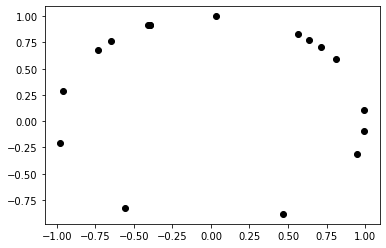

In [165]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = reduced_vectors[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = reduced_vectors[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()